Calculating global scale...
Global value range: -15.03 to 21.67
Using scale: -21.67 to 21.67
Using threshold: 4.00

Processing pIPS_right...
Group average saved to: group_average_tool_pIPS_right_1217.nii.gz


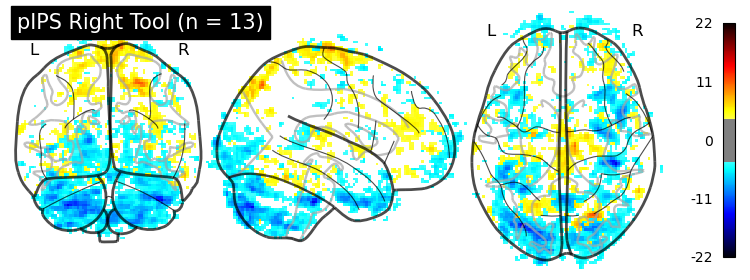


Processing pIPS_left...
Group average saved to: group_average_tool_pIPS_left_1217.nii.gz


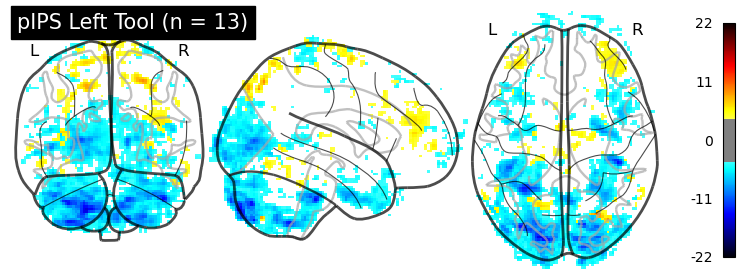


Processing LO_right...
Group average saved to: group_average_tool_LO_right_1217.nii.gz


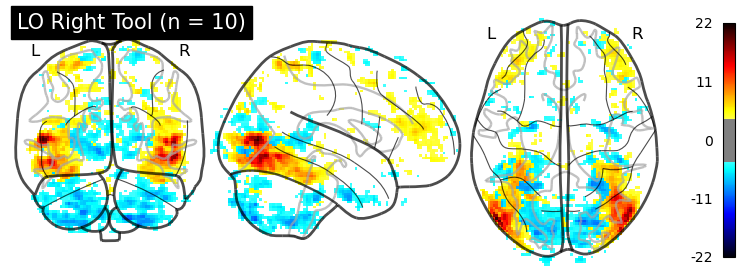


Processing LO_left...
Group average saved to: group_average_tool_LO_left_1217.nii.gz


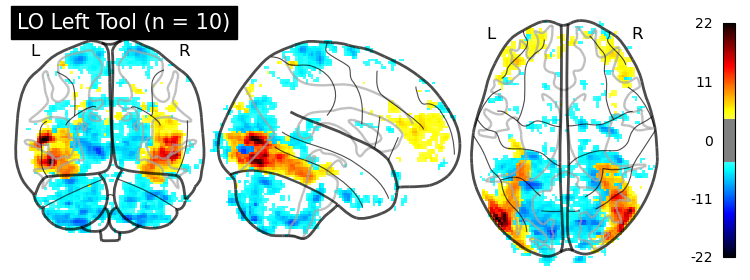


Processing complete.


In [2]:
# initial plots
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import glob
import os
import re

def load_and_average(file_pattern):
    """Helper function to load and average files"""
    files = glob.glob(file_pattern)
    
    if not files:
        print(f"No files found matching the pattern: {file_pattern}")
        return None, None, []
    
    # Extract and sort subject numbers
    subject_files = {}
    for f in files:
        match = re.search(r'sub-spaceloc(\d+)', f)  # Updated regex pattern
        if match:
            subject_files[match.group(1)] = f
    
    sorted_subjects = sorted(subject_files.keys(), key=int)
    
    # Load all images
    images = [nib.load(subject_files[subject]) for subject in sorted_subjects]
    
    # Check if all images have the same shape
    shapes = [img.shape for img in images]
    if len(set(shapes)) > 1:
        print("Error: Not all images have the same shape.")
        return None, None, []
    
    # Calculate the average
    avg_data = np.mean([img.get_fdata() for img in images], axis=0)
    avg_img = nib.Nifti1Image(avg_data, images[0].affine, images[0].header)
    
    return avg_data, avg_img, sorted_subjects

def find_global_scale(base_path, regions):
    """Find global min and max values across all group averages"""
    all_averages = []
    
    for region in regions:
        file_pattern = f'{base_path}/sub-spaceloc*/ses-01/derivatives/gca/combined_tool_{region}_mni_1217.nii.gz'  # Updated pattern
        avg_data, _, _ = load_and_average(file_pattern)
        if avg_data is not None:
            all_averages.append(avg_data)
    
    if all_averages:
        global_min = min(np.min(avg) for avg in all_averages)
        global_max = max(np.max(avg) for avg in all_averages)
        return global_min, global_max
    return None, None

def group_average(file_pattern, region, vmin, vmax, threshold):
    # Load and average data
    avg_data, avg_img, sorted_subjects = load_and_average(file_pattern)
    
    if avg_img is None:
        return
    
    # Save the average image
    output_path = f'group_average_tool_{region}_1217.nii.gz'  # Updated filename
    nib.save(avg_img, output_path)
    print(f"Group average saved to: {output_path}")

    # Format the title: split the region name and format it nicely
    region_parts = region.split('_')
    if len(region_parts) == 2:
        title = f"{region_parts[0]} {region_parts[1].capitalize()} Tool (n = {len(sorted_subjects)})"  # Added 'Tool'

    # Display the average image with consistent scaling
    plotting.plot_glass_brain(avg_img, threshold=threshold, colorbar=True, 
                            plot_abs=False, vmin=vmin, vmax=vmax,
                            title=title)
    plt.show()

# Base path
base_path = '/lab_data/behrmannlab/vlad/ptoc'

# Regions to process
regions = ['pIPS_right', 'pIPS_left', 'LO_right', 'LO_left']

# First find global min and max
print("Calculating global scale...")
global_min, global_max = find_global_scale(base_path, regions)
print(f"Global value range: {global_min:.2f} to {global_max:.2f}")

# Set symmetric limits based on the absolute maximum value
sym_max = max(abs(global_min), abs(global_max))
vmin, vmax = -sym_max, sym_max
##to manually set the scales replace the above line with the following line
#vmin, vmax = -25, 25

# Set threshold as a percentage of the maximum value (e.g., 10%)
#threshold = 0.1 * sym_max 
threshold = 4

print(f"Using scale: {vmin:.2f} to {vmax:.2f}")
print(f"Using threshold: {threshold:.2f}")

# Loop through regions
for region in regions:
    print(f"\nProcessing {region}...")
    file_pattern = f'{base_path}/sub-spaceloc*/ses-01/derivatives/gca/combined_tool_{region}_mni_1217.nii.gz'
    group_average(file_pattern, region, vmin=vmin, vmax=vmax, threshold=threshold)

print("\nProcessing complete.")

In [5]:
import numpy as np
from scipy.linalg import polar

subjects = ['sub-spaceloc1001', 'sub-spaceloc1002', 'sub-spaceloc1003', 'sub-spaceloc1004']

matrices = {}
for sub in subjects:
    mat_path = f"/user_data/csimmon2/temp_derivatives/{sub}/ses-01/derivatives/fc/anat2mni.mat"
    matrices[sub] = np.loadtxt(mat_path)

# Compare each pair
for i, sub1 in enumerate(subjects):
    for sub2 in subjects[i+1:]:
        diff = np.abs(matrices[sub1] - matrices[sub2]).max()
        trans_diff = matrices[sub1][:3,3] - matrices[sub2][:3,3]
        
        print(f"\n{sub1} vs {sub2}:")
        print(f"Max difference: {diff}")
        print(f"Translation difference: {trans_diff}")
        



sub-spaceloc1001 vs sub-spaceloc1002:
Max difference: 7.801603370000002
Translation difference: [ 3.89701158 -7.80160337 -1.87551423]

sub-spaceloc1001 vs sub-spaceloc1003:
Max difference: 6.04981454
Translation difference: [6.04981454 2.45584025 1.0339199 ]

sub-spaceloc1001 vs sub-spaceloc1004:
Max difference: 13.087236709999999
Translation difference: [  3.41686009   9.27235716 -13.08723671]

sub-spaceloc1002 vs sub-spaceloc1003:
Max difference: 10.257443620000004
Translation difference: [ 2.15280296 10.25744362  2.90943413]

sub-spaceloc1002 vs sub-spaceloc1004:
Max difference: 17.07396053
Translation difference: [ -0.48015149  17.07396053 -11.21172248]

sub-spaceloc1003 vs sub-spaceloc1004:
Max difference: 14.12115661
Translation difference: [ -2.63295445   6.81651691 -14.12115661]


In [6]:
import nibabel as nib
import numpy as np
import glob
import os

# For tool data
base_path = '/lab_data/behrmannlab/vlad/ptoc'
region = 'pIPS_right'  # or 'pIPS_left'
file_pattern = f'{base_path}/sub-spaceloc*/ses-01/derivatives/gca/combined_tool_{region}_mni_1217.nii.gz'

files = glob.glob(file_pattern)
for f in files:
   img = nib.load(f)
   data = img.get_fdata()
   print(f"\nFile: {os.path.basename(f)}")
   print(f"Min: {np.min(data):.2f}")
   print(f"Max: {np.max(data):.2f}")
   print(f"Mean: {np.mean(data):.2f}")
   print(f"Std: {np.std(data):.2f}")
   print(f"Non-zero values: {np.count_nonzero(data)}")
   print(f"Total voxels: {data.size}")


File: combined_tool_pIPS_right_mni_1217.nii.gz
Min: -20.83
Max: 20.17
Mean: -0.11
Std: 1.38
Non-zero values: 311662
Total voxels: 902629

File: combined_tool_pIPS_right_mni_1217.nii.gz
Min: -20.06
Max: 23.34
Mean: 0.28
Std: 1.74
Non-zero values: 310216
Total voxels: 902629

File: combined_tool_pIPS_right_mni_1217.nii.gz
Min: -62.46
Max: 40.61
Mean: -0.07
Std: 3.05
Non-zero values: 289777
Total voxels: 902629

File: combined_tool_pIPS_right_mni_1217.nii.gz
Min: -20.97
Max: 34.17
Mean: 0.11
Std: 1.68
Non-zero values: 332665
Total voxels: 902629

File: combined_tool_pIPS_right_mni_1217.nii.gz
Min: -62.20
Max: 53.47
Mean: -0.04
Std: 3.70
Non-zero values: 294002
Total voxels: 902629

File: combined_tool_pIPS_right_mni_1217.nii.gz
Min: -70.77
Max: 33.07
Mean: -0.25
Std: 2.28
Non-zero values: 367737
Total voxels: 902629

File: combined_tool_pIPS_right_mni_1217.nii.gz
Min: -33.75
Max: 22.14
Mean: -0.12
Std: 1.75
Non-zero values: 324285
Total voxels: 902629

File: combined_tool_pIPS_right_mni_

In [7]:
region = 'pIPS_right'
file_pattern = f'{base_path}/sub-*/ses-01/derivatives/gca/combined_object_{region}_mni.nii.gz'

files = glob.glob(file_pattern)
for f in files:
    img = nib.load(f)
    data = img.get_fdata()
    print(f"\nFile: {os.path.basename(f)}")
    print(f"Min: {np.min(data):.2f}")
    print(f"Max: {np.max(data):.2f}")
    print(f"Mean: {np.mean(data):.2f}")
    print(f"Std: {np.std(data):.2f}")
    print(f"Non-zero values: {np.count_nonzero(data)}")
    print(f"Total voxels: {data.size}")


File: combined_object_pIPS_right_mni.nii.gz
Min: -23.11
Max: 15.10
Mean: -0.05
Std: 1.01
Non-zero values: 329412
Total voxels: 902629

File: combined_object_pIPS_right_mni.nii.gz
Min: -35.01
Max: 15.06
Mean: -0.76
Std: 2.42
Non-zero values: 347407
Total voxels: 902629

File: combined_object_pIPS_right_mni.nii.gz
Min: -31.84
Max: 70.56
Mean: 0.08
Std: 2.81
Non-zero values: 308634
Total voxels: 902629

File: combined_object_pIPS_right_mni.nii.gz
Min: -22.55
Max: 22.67
Mean: 0.05
Std: 1.99
Non-zero values: 305398
Total voxels: 902629

File: combined_object_pIPS_right_mni.nii.gz
Min: -52.50
Max: 75.13
Mean: -0.09
Std: 2.27
Non-zero values: 329871
Total voxels: 902629

File: combined_object_pIPS_right_mni.nii.gz
Min: -28.63
Max: 37.59
Mean: 0.02
Std: 1.93
Non-zero values: 303993
Total voxels: 902629

File: combined_object_pIPS_right_mni.nii.gz
Min: -19.31
Max: 28.63
Mean: -0.05
Std: 1.34
Non-zero values: 319250
Total voxels: 902629

File: combined_object_pIPS_right_mni.nii.gz
Min: -37.14
M

In [3]:
import nibabel as nib
import numpy as np
import glob
import os

# FSL directory is already /usr/share/fsl on most systems
cerebellum_mask = nib.load("/user_data/csimmon2/git_repos/ptoc/Cerebellum-MNIflirt-maxprob-thr25-2mm.nii.gz")

base_path = '/lab_data/behrmannlab/vlad/ptoc'
region = 'pIPS_right'
file_pattern = f'{base_path}/sub-spaceloc*/ses-01/derivatives/gca/combined_tool_{region}_mni_1217.nii.gz'

files = glob.glob(file_pattern)
for f in files:
   img = nib.load(f)
   data = img.get_fdata()
   cerebellar_data = data[cerebellum_mask.get_fdata() > 0]
   print(f"\nCerebellar values for {os.path.basename(f)}")
   print(f"Min: {np.min(cerebellar_data):.2f}")
   print(f"Max: {np.max(cerebellar_data):.2f}")
   print(f"Mean: {np.mean(cerebellar_data):.2f}")
   print(f"Std: {np.std(cerebellar_data):.2f}")


Cerebellar values for combined_tool_pIPS_right_mni_1217.nii.gz
Min: -16.49
Max: 17.14
Mean: -0.45
Std: 3.00

Cerebellar values for combined_tool_pIPS_right_mni_1217.nii.gz
Min: -13.95
Max: 20.41
Mean: 0.38
Std: 2.89

Cerebellar values for combined_tool_pIPS_right_mni_1217.nii.gz
Min: -52.36
Max: 38.46
Mean: -0.54
Std: 7.87

Cerebellar values for combined_tool_pIPS_right_mni_1217.nii.gz
Min: -12.65
Max: 19.63
Mean: 1.28
Std: 3.52

Cerebellar values for combined_tool_pIPS_right_mni_1217.nii.gz
Min: -61.94
Max: 37.78
Mean: -2.08
Std: 8.72

Cerebellar values for combined_tool_pIPS_right_mni_1217.nii.gz
Min: -37.62
Max: 13.79
Mean: -1.46
Std: 4.05

Cerebellar values for combined_tool_pIPS_right_mni_1217.nii.gz
Min: -23.96
Max: 20.43
Mean: -0.07
Std: 3.39

Cerebellar values for combined_tool_pIPS_right_mni_1217.nii.gz
Min: -60.26
Max: 27.96
Mean: 0.26
Std: 5.87


In [4]:
# cerebellar data
file_pattern = f'{base_path}/sub-*/ses-01/derivatives/gca/combined_object_{region}_mni.nii.gz'

files = glob.glob(file_pattern)
for f in files:
    img = nib.load(f)
    data = img.get_fdata()
    cerebellar_data = data[cerebellum_mask.get_fdata() > 0]
    print(f"\nCerebellar values for {os.path.basename(f)}")
    print(f"Min: {np.min(cerebellar_data):.2f}")
    print(f"Max: {np.max(cerebellar_data):.2f}")
    print(f"Mean: {np.mean(cerebellar_data):.2f}")
    print(f"Std: {np.std(cerebellar_data):.2f}")


Cerebellar values for combined_object_pIPS_right_mni.nii.gz
Min: -13.44
Max: 10.98
Mean: 0.12
Std: 1.54

Cerebellar values for combined_object_pIPS_right_mni.nii.gz
Min: -30.67
Max: 9.31
Mean: -3.30
Std: 4.51

Cerebellar values for combined_object_pIPS_right_mni.nii.gz
Min: -31.84
Max: 54.84
Mean: -1.27
Std: 6.60

Cerebellar values for combined_object_pIPS_right_mni.nii.gz
Min: -13.53
Max: 14.19
Mean: 0.19
Std: 2.07

Cerebellar values for combined_object_pIPS_right_mni.nii.gz
Min: -21.49
Max: 21.13
Mean: 0.48
Std: 2.45

Cerebellar values for combined_object_pIPS_right_mni.nii.gz
Min: -16.39
Max: 24.90
Mean: 0.83
Std: 2.67

Cerebellar values for combined_object_pIPS_right_mni.nii.gz
Min: -18.20
Max: 12.70
Mean: -0.48
Std: 2.24

Cerebellar values for combined_object_pIPS_right_mni.nii.gz
Min: -9.51
Max: 11.40
Mean: 0.24
Std: 1.46

Cerebellar values for combined_object_pIPS_right_mni.nii.gz
Min: -14.95
Max: 18.14
Mean: 0.74
Std: 2.68

Cerebellar values for combined_object_pIPS_right_mni.

In [5]:
# compare signal values in cerebellum vs cortex
import nibabel as nib
import numpy as np
import glob
import os

#cerebellum_mask = nib.load("/usr/share/fsl/data/standard/Cerebellum-MNI-maxprob-thr25-2mm.nii.gz")
base_path = '/lab_data/behrmannlab/vlad/ptoc'
region = 'pIPS_right'

# Compare cortical vs cerebellar values
def analyze_regions(file_pattern):
   files = glob.glob(file_pattern)
   for f in files:
       img = nib.load(f)
       data = img.get_fdata()
       mask = cerebellum_mask.get_fdata() > 0
       
       cerebellar_data = data[mask]
       cortical_data = data[~mask & (data != 0)]  # Non-zero, non-cerebellar voxels
       
       print(f"\nFile: {os.path.basename(f)}")
       print("Cerebellar values:")
       print(f"Min: {np.min(cerebellar_data):.2f}")
       print(f"Max: {np.max(cerebellar_data):.2f}")
       print(f"Mean: {np.mean(cerebellar_data):.2f}")
       print(f"Std: {np.std(cerebellar_data):.2f}")
       
       print("\nCortical values:")
       print(f"Min: {np.min(cortical_data):.2f}")
       print(f"Max: {np.max(cortical_data):.2f}")
       print(f"Mean: {np.mean(cortical_data):.2f}")
       print(f"Std: {np.std(cortical_data):.2f}")

print("Tool data:")
analyze_regions(f'{base_path}/sub-spaceloc*/ses-01/derivatives/gca/combined_tool_{region}_mni_1217.nii.gz')

Tool data:

File: combined_tool_pIPS_right_mni_1217.nii.gz
Cerebellar values:
Min: -16.49
Max: 17.14
Mean: -0.45
Std: 3.00

Cortical values:
Min: -20.83
Max: 20.17
Mean: -0.30
Std: 2.28

File: combined_tool_pIPS_right_mni_1217.nii.gz
Cerebellar values:
Min: -13.95
Max: 20.41
Mean: 0.38
Std: 2.89

Cortical values:
Min: -20.06
Max: 23.34
Mean: 0.84
Std: 2.88

File: combined_tool_pIPS_right_mni_1217.nii.gz
Cerebellar values:
Min: -52.36
Max: 38.46
Mean: -0.54
Std: 7.87

Cortical values:
Min: -62.46
Max: 40.61
Mean: -0.19
Std: 5.12

File: combined_tool_pIPS_right_mni_1217.nii.gz
Cerebellar values:
Min: -12.65
Max: 19.63
Mean: 1.28
Std: 3.52

Cortical values:
Min: -20.97
Max: 34.17
Mean: 0.22
Std: 2.68

File: combined_tool_pIPS_right_mni_1217.nii.gz
Cerebellar values:
Min: -61.94
Max: 37.78
Mean: -2.08
Std: 8.72

Cortical values:
Min: -62.20
Max: 53.47
Mean: 0.02
Std: 6.24

File: combined_tool_pIPS_right_mni_1217.nii.gz
Cerebellar values:
Min: -37.62
Max: 13.79
Mean: -1.46
Std: 4.05

Cortic

In [ ]:
# compare bold signals with mask
import nibabel as nib
import numpy as np
import glob
import os
from nilearn.masking import compute_epi_mask

def compare_bold_signals(subject, run_num):
   # Tool data
   tool_path = f'/lab_data/behrmannlab/vlad/hemispace/{subject}/ses-01/derivatives/fsl/toolloc/run-0{run_num}/1stLevel.feat/filtered_func_data_reg.nii.gz'
   
   # Load and clean tool data
   tool_img = nib.load(tool_path)
   tool_mask = compute_epi_mask(tool_img)
   tool_data = tool_img.get_fdata()
   
   # Get cerebellar and cortical timeseries
   tool_cerebellar = tool_data[cerebellum_mask.get_fdata() > 0]
   tool_cortical = tool_data[~(cerebellum_mask.get_fdata() > 0) & (tool_mask.get_fdata() > 0)]
   
   print(f"\nBOLD signal stats for {subject} run {run_num}")
   print("\nCerebellar BOLD:")
   print(f"Mean: {np.mean(tool_cerebellar):.3f}")
   print(f"Std: {np.std(tool_cerebellar):.3f}")
   print(f"Temporal std: {np.std(tool_cerebellar, axis=0).mean():.3f}")
   
   print("\nCortical BOLD:")
   print(f"Mean: {np.mean(tool_cortical):.3f}")
   print(f"Std: {np.std(tool_cortical):.3f}")
   print(f"Temporal std: {np.std(tool_cortical, axis=0).mean():.3f}")

# Example usage
subject = 'sub-spaceloc1001'
compare_bold_signals(subject, 1)
compare_bold_signals(subject, 2)

In [ ]:
# compare bold si
def compare_bold_signals(subject, is_tool=True):
    if is_tool:
        base_path = f'/lab_data/behrmannlab/vlad/hemispace/{subject}/ses-01/derivatives/fsl/toolloc'
        runs = [1, 2]  # Tool has 2 runs
    else:
        base_path = f'/lab_data/behrmannlab/vlad/ptoc/{subject}/ses-01/derivatives/fsl/loc'
        runs = [1, 2, 3]  # Object has 3 runs
        
    for run in runs:
        run_path = f'{base_path}/run-0{run}/1stLevel.feat/filtered_func_data_reg.nii.gz'
        
        img = nib.load(run_path)
        mask = compute_epi_mask(img)
        data = img.get_fdata()
        
        
        cerebellar = data[cerebellum_mask.get_fdata() > 0]
        cortical = data[~(cerebellum_mask.get_fdata() > 0) & (mask.get_fdata() > 0)]
        
        print(f"\n{'Tool' if is_tool else 'Object'} BOLD stats for {subject} run {run}")
        print(f"Cerebellar - Mean: {np.mean(cerebellar):.3f}, Std: {np.std(cerebellar):.3f}")
        print(f"Cortical - Mean: {np.mean(cortical):.3f}, Std: {np.std(cortical):.3f}")

# Compare tool subject
compare_bold_signals('sub-spaceloc1001', is_tool=True)

# Compare object subject (use actual control subject ID)
compare_bold_signals('sub-025', is_tool=False)